In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Exploratory Data Analysis

## Data Investigation

In [88]:
data = pd.read_excel("./Data/online_retail_II.xlsx", sheet_name=0)
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


- Data type looks good
- Customer ID and Description have null values

In [90]:
data.describe() # for numerical values

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


For numerical variables
- Quantily and Price have negative values, which need to be investigated
- Customer ID has null values, which also need to be investigated

In [91]:
data.describe(include='O') # description for object data

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


For categorical variables
- Description has null values
- StockCode and Description have different unique values -> may need to be investigated

In [92]:
# look at missing customer data
data[data["Customer ID"].isna()]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525233,538160,20956,NaN,288,2010-12-09 17:18:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


- Null Customer ID values corresponse to negative Quantity
- Price is likely 0 <br>
-> Since we want to segment customer in this project, null customer ID will be droped

### Investigate Quantity

In [93]:
data[data["Quantity"] < 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom
525235,538162,46000M,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


- Customer ID has both null and not null values. With non null Customer ID, why this happened? <br>
It is likely that non null customer ID have Invoice id starting with letter C -> they canceled the transaction -> drop those Customer ID


In [ ]:
# Check if the starting letter of Invoice is only 'C'
data[(data["Quantity"] < 0) & (data["Customer ID"].isnull() == False)]["Invoice"].str[0].unique()

array(['C'], dtype=object)

### Investigate Invoice

In [96]:
# Verify if the Invoice is always have 6-digits interal number
data["Invoice"] = data["Invoice"].astype("str")
data[data["Invoice"].str.match("^\\d{6}$") == True]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


- Total data points is 525,461 which is greater than 515,252. The different is 10,209 </br>
-> Some mysterious data needs to be discovered. 

In [ ]:
# find the invoice that do not have C follow by 6 digits number or only 6 digit number
data[data["Invoice"].str.match("(^C\d{6}$)|(^\d{6}$)") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


- THe invoice starts with letter A, which is described as adjust bad debt. Those invoice code haven't noted in the data source. Maybe the customer buys but does not pay.
- This data is not good good for segment customer<br>
-> drop those data
-> if we drop null Customer ID, it will be resolved

### Investigate StockCode

In [ ]:
data["StockCode"]

0          85048
1         79323P
2         79323W
3          22041
4          21232
           ...  
525456     22271
525457     22750
525458     22751
525459     20970
525460     21931
Name: StockCode, Length: 525461, dtype: object

In [ ]:
# Find the stockcodes that do not follow 2 pattern: 
# having 5 digit number and 
# having 5 digit numbers follow by any characters
data["StockCode"] = data["StockCode"].astype("str")
stock_code = data[(data["StockCode"].str.match("^\d{5}[a-zA-Z]+$") == False) &
                   (data["StockCode"].str.match("^\\d{5}$") == False)]["StockCode"].unique()
stock_code

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

- As definition on the dataset: StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
- Since the values we just figured out above don't follow the pattern. I will assume these values is valid

In [122]:
for i in stock_code:
    num = len(data[data["StockCode"].str.contains(i)])
    print(f"{i}: {num}")

POST: 865
D: 6746
DCGS0058: 31
DCGS0068: 2
DOT: 736
M: 1420
DCGS0004: 4
DCGS0076: 13
C2: 138
BANK CHARGES: 65
DCGS0003: 9
TEST001: 15
gift_0001_80: 4
DCGS0072: 3
gift_0001_20: 19
DCGS0044: 1
TEST002: 2
gift_0001_10: 7
gift_0001_50: 4
DCGS0066N: 4
gift_0001_30: 21
PADS: 15
ADJUST: 70
gift_0001_40: 4
gift_0001_60: 2
gift_0001_70: 3
gift_0001_90: 2
DCGSSGIRL: 12
DCGS0006: 1
DCGS0016: 1
DCGS0027: 1
DCGS0036: 1
DCGS0039: 1
DCGS0060: 1
DCGS0056: 1
DCGS0059: 1
GIFT: 1
DCGSLBOY: 1
m: 8
DCGS0053: 1
DCGS0062: 2
DCGS0037: 2
DCGSSBOY: 12
DCGSLGIRL: 1
S: 3716
DCGS0069: 4
DCGS0070: 1
DCGS0075: 1
B: 22677
DCGS0041: 1
ADJUST2: 3
47503J : 1
C3: 1
SP1002: 3
AMAZONFEE: 9


In [120]:
# Investigate all the invalid stockcodes
for i in stock_code:
    print(data[data["StockCode"].str.contains(i)].head(5))

     Invoice StockCode Description  Quantity         InvoiceDate   Price  \
89    489439      POST     POSTAGE         3 2009-12-01 09:28:00   18.00   
126   489444      POST     POSTAGE         1 2009-12-01 09:55:00  141.00   
173   489447      POST     POSTAGE         1 2009-12-01 10:10:00  130.00   
625   489526      POST     POSTAGE         6 2009-12-01 11:50:00   18.00   
927  C489538      POST     POSTAGE        -1 2009-12-01 12:18:00    9.58   

     Customer ID         Country  
89       12682.0          France  
126      12636.0             USA  
173      12362.0         Belgium  
625      12533.0         Germany  
927      15796.0  United Kingdom  
     Invoice StockCode                       Description  Quantity  \
197  C489459    90200D          PINK SWEETHEART BRACELET        -3   
204  C489459    90003D    CRYSTAL PAIR HEART HAIR SLIDES        -3   
208  C489459    90082D  DIAMANTE BOW BROOCH BLACK COLOUR        -2   
244   489462    90200D          PINK SWEETHEART BRACE

In [130]:
stock_code_description = [
    ["POST", 865, "Postage fee", "exclude"],
    ["D", 6746, "type of product, look legit", "include"],
    ["DCGS0058", 31, "gum", "include"],
    ["DCGS0068", 2, "dog's product", "include"],
    ["DOT", 736, "postage fee", "exclude"],
    ["M", 1420, "type of product", "include"],
    ["DCGS0004", 4, "type of product", "include"],
    ["DCGS0076", 13, "type of product", "include"],
    ["C2", 138, "carriage fee/ transportation fee", "exclude"],
    ["BANK CHARGES", 65, "bank transaction fee", "exclude"],
    ["DCGS0003", 9, "class product", "include"],
    ["TEST001", 15, "test product", "exclude"],
    ["gift_0001_80", 4, "gift", "exclude"],
    ["DCGS0072", 3, "cat product", "include"],
    ["gift_0001_20", 19, "gift", "exclude"],
    ["DCGS0044", 1, "car's product", "include"],
    ["TEST002", 2, "test product", "exclude"],
    ["gift_0001_10", 7, "gift", "exclude"],
    ["gift_0001_50", 4, "gift", "exclude"],
    ["DCGS0066N", 4, "dog product", "include"],
    ["gift_0001_30", 21, "gift", "exclude"],
    ["PADS", 15, "beauty product", "include"],
    ["ADJUST", 70, "adjust transaction", "include"],
    ["gift_0001_40", 4, "gift", "exclude"],
    ["gift_0001_60", 2, "gift", "exclude"],
    ["gift_0001_70", 3, "gift", "exclude"],
    ["gift_0001_90", 2, "gift", "exclude"],
    ["DCGSSGIRL", 12, "real product", "include"],
    ["DCGS0006", 1, "not sure, n/a in description", "exclude"],
    ["DCGS0016", 1, "not sure, n/a in description", "exclude"],
    ["DCGS0027", 1, "not sure, n/a in description", "exclude"],
    ["DCGS0036", 1, "not sure, n/a in description", "exclude"],
    ["DCGS0039", 1, "not sure, n/a in description", "exclude"],
    ["DCGS0060", 1, "not sure, n/a in description", "exclude"],
    ["DCGS0056", 1, "not sure, n/a in description", "exclude"],
    ["DCGS0059", 1, "not sure, n/a in description", "exclude"],
    ["GIFT", 1, "gift", "exclude"],
    ["DCGSLBOY", 1, "not sure, n/a in description", "exclude"],
    ["m", 8, "real product", "include"],
    ["DCGS0053", 1, "not sure, n/a in description", "exclude"],
    ["DCGS0062", 2, "real product", "include"],
    ["DCGS0037", 2, "real product", "include"],
    ["DCGSSBOY", 12, "real product", "include"],
    ["DCGSLGIRL", 1, "not sure, n/a in description", "exclude"],
    ["S", 3716, "real product", "include"],
    ["DCGS0069", 4, "real product", "include"],
    ["DCGS0070", 1, "real product", "include"],
    ["DCGS0075", 1, "real product", "include"],
    ["B", 22677, "real product", "include"],
    ["DCGS0041", 1, "real product", "include"],
    ["ADJUST2", 3, "adjust transaction", "include"],
    ["47503J", 1, "real product", "include"],
    ["C3", 1, "real product", "include"],
    ["SP1002", 3, "real product", "include"],
    ["AMAZONFEE", 9, "amazon fee", "exclude"],
]
stock_code_description_df = pd.DataFrame(stock_code_description, columns=["StockCode", "Count", "Description", "Include/Exclude"])
stock_code_description_df.head()

,StockCode,Count,Description,Include/Exclude
0,POST,865,Postage fee,exclude
1,D,6746,"type of product, look legit",include
2,DCGS0058,31,gum,include
3,DCGS0068,2,dog's product,include
4,DOT,736,postage fee,exclude


### Investigate Country

In [185]:
np.sort(data["Country"].unique())

array(['Australia', 'Austria', 'Bahrain', 'Belgium', 'Bermuda', 'Brazil',
       'Canada', 'Channel Islands', 'Cyprus', 'Denmark', 'EIRE',
       'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Iceland',
       'Israel', 'Italy', 'Japan', 'Korea', 'Lebanon', 'Lithuania',
       'Malta', 'Netherlands', 'Nigeria', 'Norway', 'Poland', 'Portugal',
       'RSA', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'Thailand',
       'USA', 'United Arab Emirates', 'United Kingdom', 'Unspecified',
       'West Indies'], dtype=object)

- No misspelling country name or duplicate value due to misspelling

## Data Cleaning

In [424]:
data_cleaned = data.copy()
data_cleaned


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [425]:
# Drop null CustomerID
data_cleaned.dropna(subset="Customer ID", inplace=True)


In [426]:
mask = (
    (data_cleaned["Quantity"] > 0) &
    (data_cleaned["Price"] > 0) &
    ((data_cleaned["StockCode"].str.match("^\d{5}[a-zA-Z]+$") == True) |
    (data_cleaned["StockCode"].str.match("^\\d{5}$") == True) |
    (data_cleaned["StockCode"].isin(stock_code_description_df.loc[stock_code_description_df["Include/Exclude"] == "include"]["StockCode"])))
)
data_cleaned = data_cleaned[mask].copy()
data_cleaned


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [428]:
data_cleaned.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406776.000000,406776,406776.000000,406776.000000
mean,13.609335,2010-07-01 09:51:56.753496064,3.236689,15373.671967
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000
25%,2.000000,2010-03-26 13:57:00,1.250000,14006.000000
50%,5.000000,2010-07-09 15:20:00,1.950000,15326.000000
75%,12.000000,2010-10-14 17:09:00,3.750000,16814.000000
max,19152.000000,2010-12-09 20:01:00,10953.500000,18287.000000
std,96.944994,NaN,34.717309,1677.377414


In [192]:
# % of data remaining
len(data_cleaned)/len(data) * 100

77.5821611879854

- We droped about 33% of the data 

## Feature Engineering

In [193]:
data_cleaned

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [194]:
data_cleaned['TotalSpending'] = data_cleaned['Quantity'] * data_cleaned['Price']

In [199]:
data_agg = data_cleaned.groupby(by=['Customer ID'], as_index=False).agg(
    Monetary = ('TotalSpending', 'sum'),
    Frequency = ('Invoice', 'nunique'),
    LastInvoice = ('InvoiceDate', 'max')
)
# as_index=False: don't make Customer ID the index of the result df
data_agg

,Customer ID,Monetary,Frequency,LastInvoice
0,12346.0,372.86,11,2010-06-28 13:53:00
1,12347.0,1323.32,2,2010-12-07 14:57:00
2,12348.0,222.16,1,2010-09-27 14:59:00
3,12349.0,2671.14,3,2010-10-28 08:23:00
4,12351.0,300.93,1,2010-11-29 15:23:00
...,...,...,...,...
4307,18283.0,641.77,6,2010-11-22 15:30:00
4308,18284.0,461.68,1,2010-10-04 11:33:00
4309,18285.0,427.00,1,2010-02-17 10:24:00
4310,18286.0,1296.43,2,2010-08-20 11:57:00


In [200]:
# Recency is caculated by substract today day by the lastInvoice values
# Since we don't have live data, I will use max of LastInvoice as the today day
max_last_invoice = max(data_agg['LastInvoice'])
max_last_invoice

Timestamp('2010-12-09 20:01:00')

In [205]:
data_agg['Recency'] = (max_last_invoice - data_agg['LastInvoice']).dt.days
data_agg.drop(columns=['LastInvoice'], inplace=True)

In [206]:
data_agg.describe()

,Customer ID,Monetary,Frequency,Recency
count,4312.000000,4312.000000,4312.000000,4312.000000
mean,15349.290353,2048.238236,4.455705,90.171846
std,1701.200176,8914.481280,8.170213,96.860633
min,12346.000000,2.950000,1.000000,0.000000
25%,13882.500000,307.987500,1.000000,17.000000
50%,15350.500000,706.020000,2.000000,52.000000
75%,16834.250000,1723.142500,5.000000,135.000000
max,18287.000000,349164.350000,205.000000,373.000000


### Check outliner 
Why? Since outliner is very sensitive for K-Mean clustering model

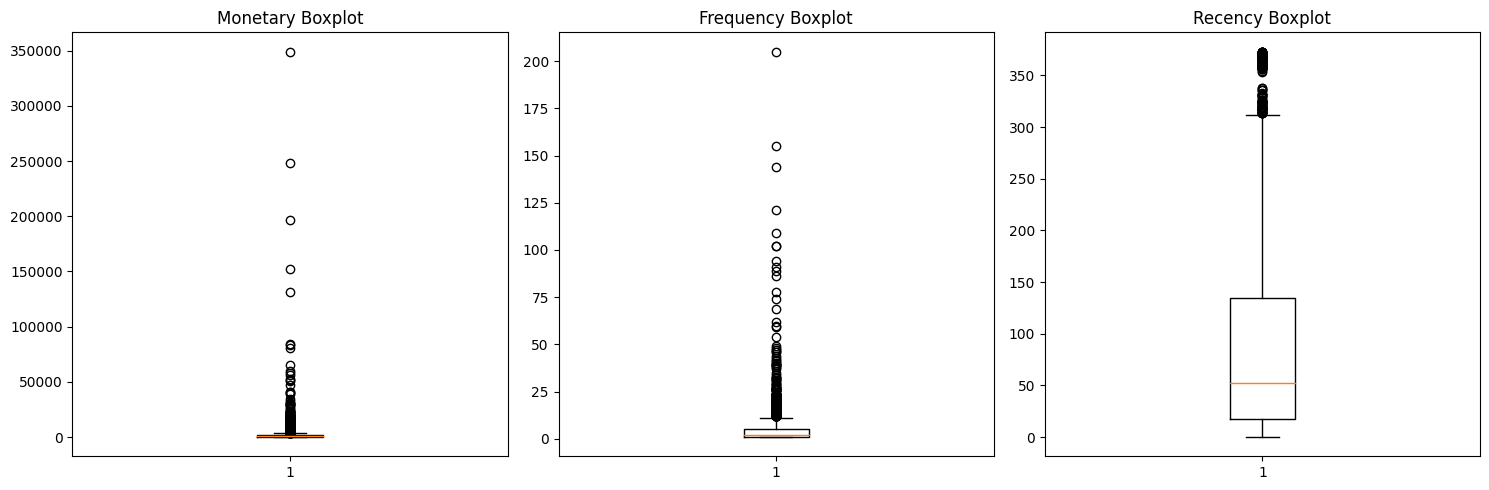

In [212]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.boxplot(data_agg['Monetary'])
plt.title('Monetary Boxplot')

plt.subplot(1,3,2)
plt.boxplot(data_agg['Frequency'])
plt.title('Frequency Boxplot')

plt.subplot(1,3,3)
plt.boxplot(data_agg['Recency'])
plt.title('Recency Boxplot')

plt.tight_layout()

- Observe the present of outliners
- I will store all outliners of those three in a seperate data frame for analysis since the outliner is important to segment the customer, especially customer spent a significant of money and buy stuff frequency -> We don't want to drop them.

In [219]:
def extract_outliner(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    return data.loc[(data[column] > (q3 + 1.5 * iqr)) | (data[column] < (q1 - 1.5 * iqr))]

In [222]:
monetary_outliner = extract_outliner(data_agg, 'Monetary')
frequency_outliner = extract_outliner(data_agg, 'Frequency')
recency_outliner = extract_outliner(data_agg, 'Recency')


- The data in monetary_outliner, frequency_outliner, frequency_outliner can be dublicated
- The dublicate/common value can be a valuable class because we want to pay more attention on customer who pay more and recent and frequent

In [221]:
monetary_outliner.describe()

,Customer ID,Monetary,Frequency,Recency
count,428.000000,428.000000,428.000000,428.000000
mean,15060.060748,12319.513145,17.280374,29.883178
std,1729.846873,26044.459639,20.487179,49.228287
min,12357.000000,3851.010000,1.000000,0.000000
25%,13573.000000,4610.065000,8.000000,3.000000
50%,14927.000000,6262.580000,12.000000,13.000000
75%,16653.000000,10409.572500,18.000000,31.000000
max,18260.000000,349164.350000,205.000000,326.000000


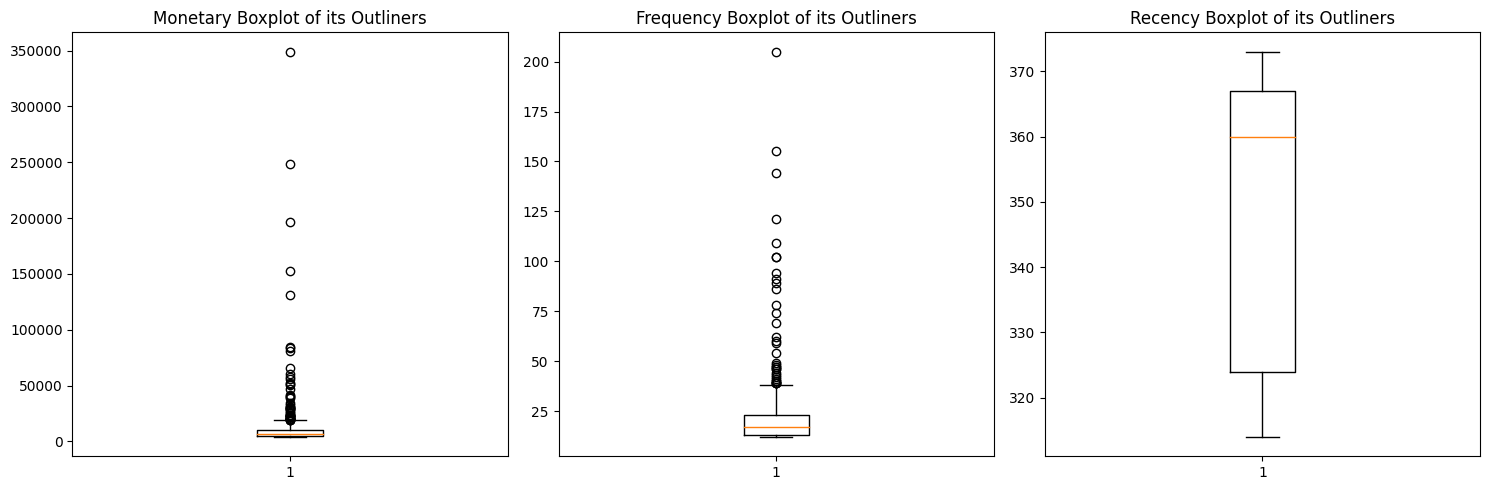

In [225]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.boxplot(monetary_outliner['Monetary'])
plt.title('Monetary Boxplot of its Outliners')

plt.subplot(1,3,2)
plt.boxplot(frequency_outliner['Frequency'])
plt.title('Frequency Boxplot of its Outliners')

plt.subplot(1,3,3)
plt.boxplot(recency_outliner['Recency'])
plt.title('Recency Boxplot of its Outliners')

plt.tight_layout()

- The outliners of outliner data is acceptable
- The recency boxplot show that the recency outliner is over 320 days. Those customer are likely to churn with us. The futher clustering don't need to include recency 

In [245]:
data_excluded_outliner = data_agg.loc[~(data_agg['Customer ID'].isin(monetary_outliner['Customer ID'])) & ~ (data_agg['Customer ID'].isin(frequency_outliner['Customer ID']))] # can use data_agg.index to filter
data_excluded_outliner

,Customer ID,Monetary,Frequency,Recency
0,12346.0,372.86,11,164
1,12347.0,1323.32,2,2
2,12348.0,222.16,1,73
3,12349.0,2671.14,3,42
4,12351.0,300.93,1,10
...,...,...,...,...
4307,18283.0,641.77,6,17
4308,18284.0,461.68,1,66
4309,18285.0,427.00,1,295
4310,18286.0,1296.43,2,111


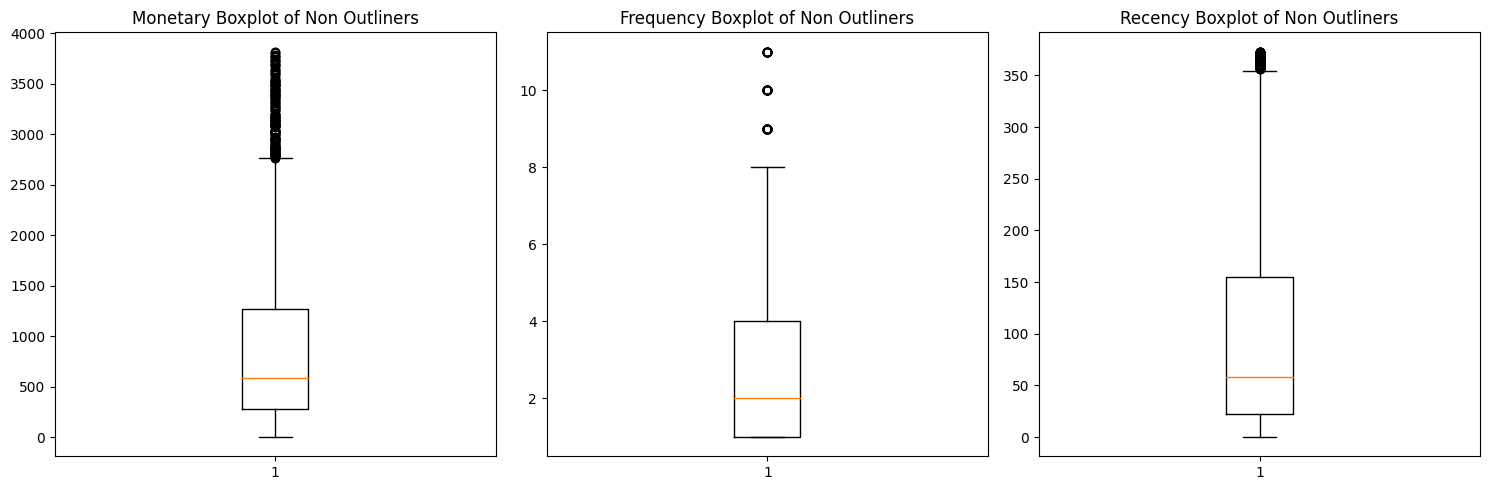

In [246]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.boxplot(data_excluded_outliner['Monetary'])
plt.title('Monetary Boxplot of Non Outliners')

plt.subplot(1,3,2)
plt.boxplot(data_excluded_outliner['Frequency'])
plt.title('Frequency Boxplot of Non Outliners')

plt.subplot(1,3,3)
plt.boxplot(data_excluded_outliner['Recency'])
plt.title('Recency Boxplot of Non Outliners')

plt.tight_layout()
plt.show()

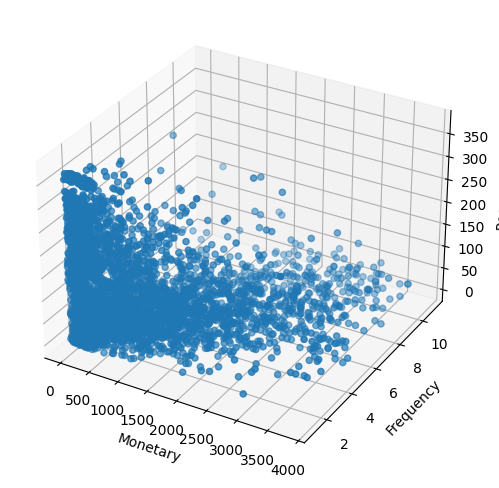

In [253]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection = '3d')

scatter_plot = ax.scatter(data_excluded_outliner['Monetary'], data_excluded_outliner['Frequency'], data_excluded_outliner['Recency'])
ax.set_xlabel("Monetary")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

plt.show()


- The scales of Monetary, Frequency, Recency differ
- Since K-Means is sensitive to scale due to its reliance on distance, we need to standardize the data to avoid bias toward high-scale features

In [255]:
data_excluded_outliner

,Customer ID,Monetary,Frequency,Recency
0,12346.0,372.86,11,164
1,12347.0,1323.32,2,2
2,12348.0,222.16,1,73
3,12349.0,2671.14,3,42
4,12351.0,300.93,1,10
...,...,...,...,...
4307,18283.0,641.77,6,17
4308,18284.0,461.68,1,66
4309,18285.0,427.00,1,295
4310,18286.0,1296.43,2,111


In [258]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data_excluded_outliner[['Monetary', 'Frequency', 'Recency']])
data_excluded_outliner_scaled = pd.DataFrame(scaled, columns=['Monetary', 'Frequency', 'Recency'], index=data_excluded_outliner.index)
data_excluded_outliner_scaled

,Monetary,Frequency,Recency
0,-0.626900,3.629758,0.669431
1,0.525592,-0.385668,-0.971424
2,-0.809633,-0.831827,-0.252284
3,2.159908,0.060490,-0.566275
4,-0.714119,-0.831827,-0.890395
...,...,...,...
4307,-0.300830,1.398966,-0.819493
4308,-0.519200,-0.831827,-0.323185
4309,-0.561251,-0.831827,1.996295
4310,0.492986,-0.385668,0.132608


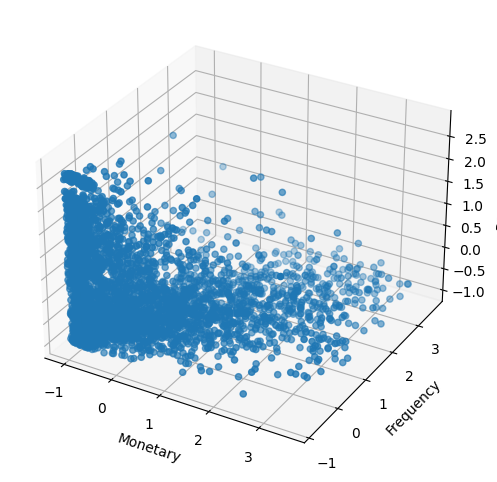

In [260]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection = '3d')

scatter_plot = ax.scatter(data_excluded_outliner_scaled['Monetary'], data_excluded_outliner_scaled['Frequency'], data_excluded_outliner_scaled['Recency'])
ax.set_xlabel("Monetary")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

plt.show()

# K-Means Clustering

## Define the number of cluster for non outliners data
Using metrix: 
- Elbow
- Sildouette Score

In [276]:
k = 10
inertia = []
sildouette_score = []
k_label = range(2, k + 1) # start from 2 since num of cluster > 1
for i in k_label: 
    kmeans = KMeans(n_clusters=i, max_iter=500, random_state=42)
    cluster_labels = kmeans.fit_predict(data_excluded_outliner_scaled)
    inertia.append(kmeans.inertia_)
    sildouette_score.append(silhouette_score(data_excluded_outliner_scaled, cluster_labels))

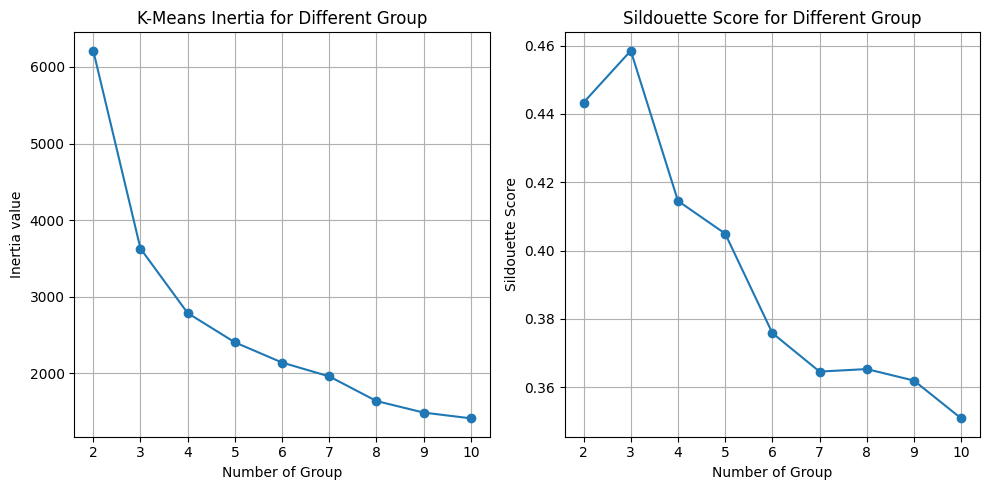

In [283]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(k_label, inertia, marker = 'o')
plt.xlabel("Number of Group")
plt.ylabel("Inertia value")
plt.title("K-Means Inertia for Different Group")
plt.xticks(k_label) # avoid float value on the x axis
plt.grid()

plt.subplot(1,2,2)
plt.plot(k_label, sildouette_score, marker = 'o')
plt.xlabel("Number of Group")
plt.ylabel("Sildouette Score")
plt.title("Sildouette Score for Different Group")
plt.xticks(k_label) # avoid float value on the x axis
plt.grid()

plt.tight_layout()
plt.show()

- The optimal k could be 4 or 5
- To determine 4 or 5, use Sildouette score
- Since Sildouette score at 4 is greater than the one at 5 -> choose 4 clusters

In [284]:
kmeans = KMeans(n_clusters=4, max_iter=500, random_state=42)
cluster_labels = kmeans.fit_predict(data_excluded_outliner_scaled)
cluster_labels

array([3, 2, 1, ..., 0, 2, 2], dtype=int32)

In [286]:
data_excluded_outliner['Cluster'] = cluster_labels
data_excluded_outliner

/var/folders/0w/h84qx3f937d2llw5q1t2z7040000gn/T/ipykernel_50097/3780520092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_excluded_outliner['Cluster'] = cluster_labels


,Customer ID,Monetary,Frequency,Recency,Cluster
0,12346.0,372.86,11,164,3
1,12347.0,1323.32,2,2,2
2,12348.0,222.16,1,73,1
3,12349.0,2671.14,3,42,2
4,12351.0,300.93,1,10,1
...,...,...,...,...,...
4307,18283.0,641.77,6,17,2
4308,18284.0,461.68,1,66,1
4309,18285.0,427.00,1,295,0
4310,18286.0,1296.43,2,111,2


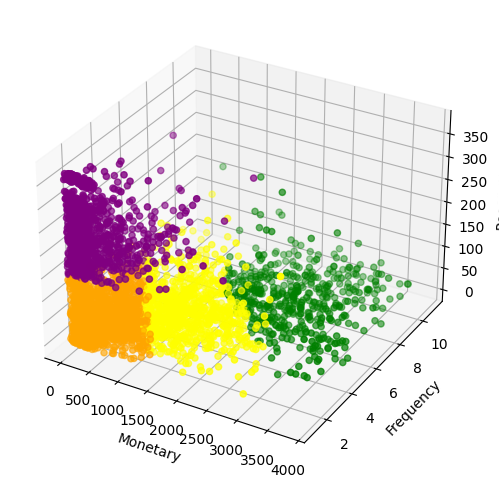

In [313]:
color_set = {
    0: 'purple',
    1: 'orange',
    2: 'yellow',
    3: 'green'
}
color_map = data_excluded_outliner['Cluster'].map(color_set)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_excluded_outliner['Monetary'], data_excluded_outliner['Frequency'], data_excluded_outliner['Recency'], c= color_map)
ax.set_xlabel("Monetary")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

plt.show()

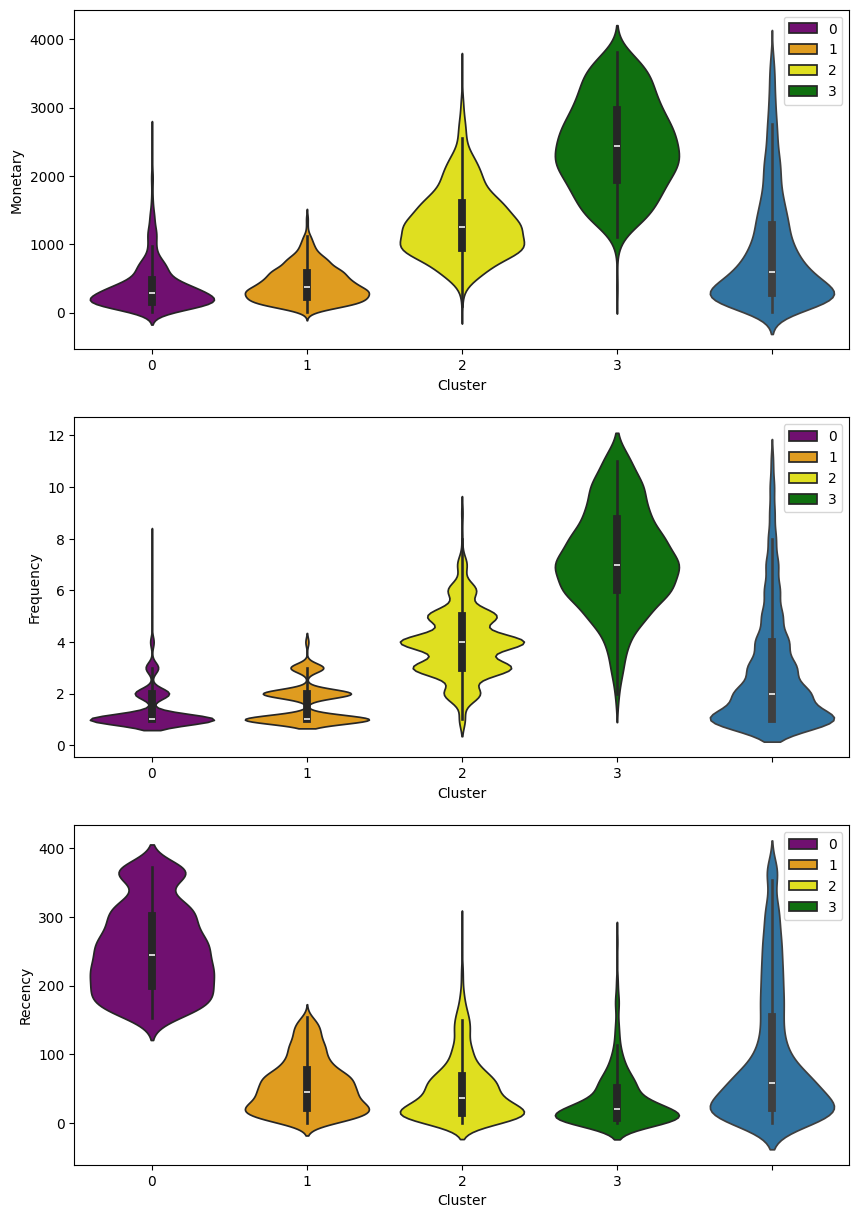

In [314]:
fig = plt.figure(figsize=(10, 15))
plt.subplot(3,1,1)
sns.violinplot(x = data_excluded_outliner["Cluster"], y = data_excluded_outliner["Monetary"], hue= data_excluded_outliner["Cluster"], palette=color_set)
sns.violinplot(y=data_excluded_outliner['Monetary'])

plt.subplot(3,1,2)
sns.violinplot(x = data_excluded_outliner["Cluster"], y = data_excluded_outliner["Frequency"], hue= data_excluded_outliner["Cluster"], palette=color_set)
sns.violinplot(y=data_excluded_outliner['Frequency'])

plt.subplot(3,1,3)
sns.violinplot(x = data_excluded_outliner["Cluster"], y = data_excluded_outliner["Recency"], hue= data_excluded_outliner["Cluster"], palette=color_set)
sns.violinplot(y=data_excluded_outliner['Recency'])
plt.tight_layout
plt.show()

Blue violin plot represent the whole data. We use it to compare to each cluster
1.  Cluster 0 (Purple): Trigging
- Mean of monetary and frequency are lower than the total mean but mean of recency is higher than the total mean. Customers in this group spent less money and not frequency but more recent. They can be a return customer 
- We want to keep them with us by provide welcome back discount, remind or suggest items that relevant to their need.

2. Cluster 1 (orange): Maintain
- Mean of monetary, frequency, and recency are lower than the total mean. Customer in this group doesn't engage too much, they have budget but didn't shopping regulaly.
- We want to show them that whenever they need shoping, we are their fist choice by suggesting relevant products. Provide great service and offer custom promotion to encourage more purchase

3. Cluster 2 (yellow): Retain
- Mean of monetary and frequency are higher than the total mean but mean of recency is lower than the total mean. They are high spending customer.
- We want to keep them engage with us and don't want them to leave by suggesting promotion to attract them, having them come back.

4. Cluster 3 (green): Focus
- Mean of monetary and frequency are higher than the total mean but mean of recency is lower than the total mean. They are even a higher spending and the most loyal customer.
- We want to keep them at all cost by launch a loyal customer program, show recognize and offer exclusive offer.


## For Outliners Data
<br> We want to focus on the outliner of monetary and frequency since recency's outliner is greater than 325 days

In [335]:
# Find common data of monetary and frequency
common_index = monetary_outliner.loc[monetary_outliner.index.isin(frequency_outliner.index)].index
monetary_frequency_outliner = monetary_outliner[monetary_outliner.index.isin(common_index)]
monetary_outliner.drop(common_index, inplace=True)
frequency_outliner.drop(common_index, inplace=True)
monetary_outliner['Cluster'] = -1
frequency_outliner['Cluster'] = -2
monetary_frequency_outliner['Cluster'] = -3
merge_outliner = pd.concat([monetary_outliner, frequency_outliner, monetary_frequency_outliner])
merge_outliner

/var/folders/0w/h84qx3f937d2llw5q1t2z7040000gn/T/ipykernel_50097/89657591.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monetary_outliner.drop(common_index, inplace=True)
/var/folders/0w/h84qx3f937d2llw5q1t2z7040000gn/T/ipykernel_50097/89657591.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frequency_outliner.drop(common_index, inplace=True)
/var/folders/0w/h84qx3f937d2llw5q1t2z7040000gn/T/ipykernel_50097/89657591.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,Customer ID,Monetary,Frequency,Recency,Cluster
9,12357.0,12079.99,2,23,-1
26,12380.0,6951.49,7,100,-1
44,12409.0,12346.62,4,55,-1
50,12415.0,19543.84,7,10,-1
64,12433.0,7205.39,5,1,-1
...,...,...,...,...,...
4262,18223.0,7516.31,12,22,-3
4263,18225.0,7545.14,15,0,-3
4264,18226.0,6650.83,15,13,-3
4268,18231.0,4797.70,23,41,-3


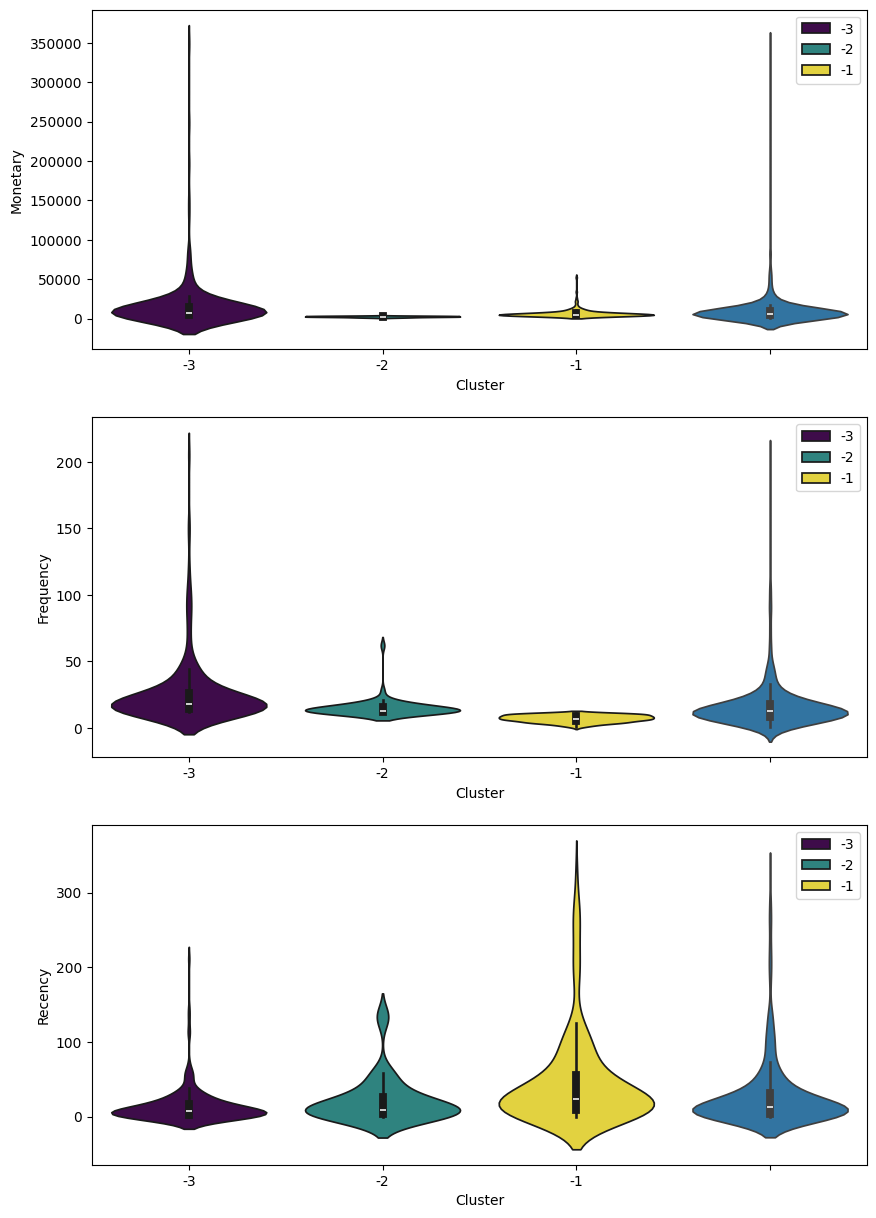

In [337]:
fig = plt.figure(figsize=(10, 15))
plt.subplot(3,1,1)
sns.violinplot(x = merge_outliner["Cluster"], y = merge_outliner["Monetary"], hue= merge_outliner["Cluster"], palette='viridis')
sns.violinplot(y=merge_outliner['Monetary'])

plt.subplot(3,1,2)
sns.violinplot(x = merge_outliner["Cluster"], y = merge_outliner["Frequency"], hue= merge_outliner["Cluster"], palette='viridis')
sns.violinplot(y=merge_outliner['Frequency'])

plt.subplot(3,1,3)
sns.violinplot(x = merge_outliner["Cluster"], y = merge_outliner["Recency"], hue= merge_outliner["Cluster"], palette='viridis')
sns.violinplot(y=merge_outliner['Recency'])
plt.tight_layout
plt.show()

Blue violin plot represent the whole data. We use it to compare to each cluster
1.  Cluster -3 (Purple): VIP
- High spending, high frequency. This group need special attention.
- Remain close relationship with them by offer great VIP service and loyal customer program

2.  Cluster -2 (Green): Active
- Less spending but highly engage with us recently. They buying power is good.
- Provide bundle to leverage their puying power and implement loyal program to strigger their spending per visit

3.  Cluster -1 (Yellow): Customize
- High spending speding group but not shoping alcoholic
- We should maintain a good relationship with them with personalize offer to unlease their high spending capacity


Blue violin plot represent the whole data. We use it to compare to each cluster
1.  Cluster 0 (Purple): Trigging
- Mean of monetary and frequency are lower than the total mean but mean of recency is higher than the total mean. Customers in this group spent less money and not frequency but more recent. They can be a return customer 
- We want to keep them with us by provide welcome back discount, remind or suggest items that relevant to their need.

2. Cluster 1 (orange): Maintain
- Mean of monetary, frequency, and recency are lower than the total mean. Customer in this group doesn't engage too much, they have budget but didn't shopping regulaly.
- We want to show them that whenever they need shoping, we are their fist choice by suggesting relevant products. Provide great service and offer custom promotion to encourage more purchase

3. Cluster 2 (yellow): Retain
- Mean of monetary and frequency are higher than the total mean but mean of recency is lower than the total mean. They are high spending customer.
- We want to keep them engage with us and don't want them to leave by suggesting promotion to attract them, having them come back.

4. Cluster 3 (green): Focus
- Mean of monetary and frequency are higher than the total mean but mean of recency is lower than the total mean. They are even a higher spending and the most loyal customer.
- We want to keep them at all cost by launch a loyal customer program, show recognize and offer exclusive offer.


# Visualization

In [340]:
cluster_label = {
    -3: 'VIP',
    -2: 'Active',
    -1: 'Customize',
    0: 'Trigging',
    1: 'Maintain',
    2: 'Retain',
    3: 'Focus'
}

final_data = pd.concat([merge_outliner, data_excluded_outliner])
final_data['Cluster Name'] = final_data['Cluster'].map(cluster_label)
final_data

,Customer ID,Monetary,Frequency,Recency,Cluster,Cluster Name
9,12357.0,12079.99,2,23,-1,Customize
26,12380.0,6951.49,7,100,-1,Customize
44,12409.0,12346.62,4,55,-1,Customize
50,12415.0,19543.84,7,10,-1,Customize
64,12433.0,7205.39,5,1,-1,Customize
...,...,...,...,...,...,...
4307,18283.0,641.77,6,17,2,Retain
4308,18284.0,461.68,1,66,1,Maintain
4309,18285.0,427.00,1,295,0,Trigging
4310,18286.0,1296.43,2,111,2,Retain


In [343]:
final_data['Cluster Name'].value_counts()

Cluster Name
Maintain     1506
Trigging      915
Retain        913
Focus         494
VIP           229
Customize     199
Active         56
Name: count, dtype: int64

/var/folders/0w/h84qx3f937d2llw5q1t2z7040000gn/T/ipykernel_50097/2029665356.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(final_data['Cluster Name'].value_counts(), ax = ax, palette='viridis')


Text(0, 0.5, 'Average Values')

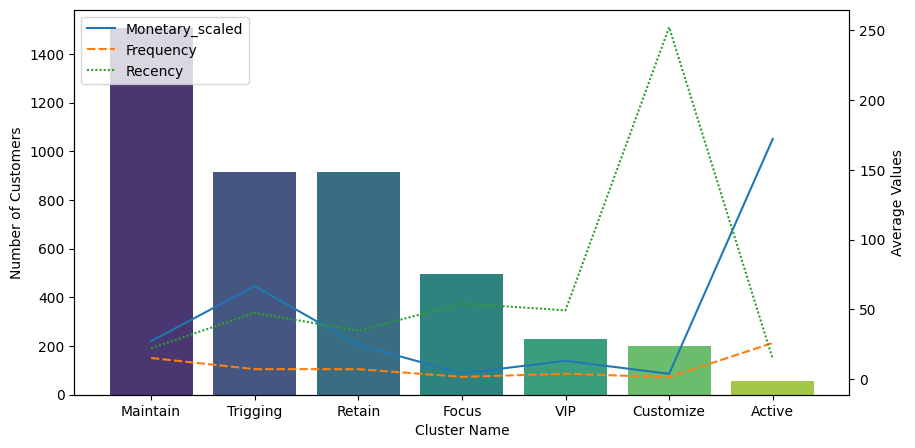

In [359]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
sns.barplot(final_data['Cluster Name'].value_counts(), ax = ax, palette='viridis')
ax.set_ylabel('Number of Customers')

ax2 = plt.twinx()
lineplot_data = final_data.groupby(by=['Cluster Name']).mean().reset_index()[['Cluster Name', 'Monetary', 'Frequency', 'Recency']]
lineplot_data['Monetary_scaled'] = lineplot_data['Monetary'] / 100
sns.lineplot(data = lineplot_data[['Cluster Name', 'Monetary_scaled', 'Frequency', 'Recency']], ax = ax2)
ax2.set_ylabel('Average Values')


# Market Basket Analysis

In [429]:
market_basket_data = data_cleaned.merge(final_data, on='Customer ID', how='left', suffixes=('_cleaned', '_final'))
market_basket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406776 entries, 0 to 406775
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Invoice       406776 non-null  object        
 1   StockCode     406776 non-null  object        
 2   Description   406776 non-null  object        
 3   Quantity      406776 non-null  int64         
 4   InvoiceDate   406776 non-null  datetime64[ns]
 5   Price         406776 non-null  float64       
 6   Customer ID   406776 non-null  float64       
 7   Country       406776 non-null  object        
 8   Monetary      406776 non-null  float64       
 9   Frequency     406776 non-null  int64         
 10  Recency       406776 non-null  int64         
 11  Cluster       406776 non-null  int64         
 12  Cluster Name  406776 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 40.3+ MB


# Group 0

In [430]:
group0 = market_basket_data[market_basket_data.Cluster == 0]

In [435]:
group0

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Monetary,Frequency,Recency,Cluster,Cluster Name
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2017.20,6,314,0,Trigging
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2017.20,6,314,0,Trigging
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2017.20,6,314,0,Trigging
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2017.20,6,314,0,Trigging
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2017.20,6,314,0,Trigging
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202519,515150,85231G,ORANGE SCENTED SET/9 T-LIGHTS,12,2010-07-08 14:48:00,0.85,18279.0,United Kingdom,231.34,1,154,0,Trigging
202520,515150,85231B,CINAMMON SET OF 9 T-LIGHTS,24,2010-07-08 14:48:00,0.85,18279.0,United Kingdom,231.34,1,154,0,Trigging
202521,515150,20733,GOLD MINI TAPE MEASURE,10,2010-07-08 14:48:00,0.85,18279.0,United Kingdom,231.34,1,154,0,Trigging
202522,515150,20738,GREEN MINI TAPE MEASURE,10,2010-07-08 14:48:00,0.85,18279.0,United Kingdom,231.34,1,154,0,Trigging


In [440]:
# Create a basket for Group 1
def one(x):
    if sum(x) == 0:
        return 0
    else:
        return 1

my_basket = pd.get_dummies(group0, columns=['Description'], prefix='')
my_basket.columns = my_basket.columns.str.replace('_', '')
my_basket.columns = my_basket.columns.str.replace('*', '')
my_basket = my_basket.drop(columns=['StockCode', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Monetary', 'Frequency', 'Recency',
       'Cluster', 'Cluster Name'])
my_basket = my_basket.groupby('Invoice').agg(one)
my_basket

,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,ANIMAL STICKERS,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,FAIRY CAKE CANDLES,FLAMINGO LIGHTS,HOME SWEET HOME BLACKBOARD,IVORY PAPER CUP CAKE CASES,NEW BAROQUE BLACK BOXES,...,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE DOUBLE PLANTER,ZINC HEART LATTICE PLANTER BOWL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
515008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
515025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [439]:
# ibraries required for market basket analysis
!pip install mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.6 MB/s eta 0:00:00a 0:00:01


In [441]:
frequent_itemsets_group0 = apriori(my_basket,  min_support=0.07, use_colnames=True)
frequent_itemsets_group0

/opt/homebrew/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.079755,(BAKING SET 9 PIECE RETROSPOT )
1,0.144939,(WHITE HANGING HEART T-LIGHT HOLDER)


In [446]:
#Build frequent itemsets
frequent_itemsets_group0['length'] = frequent_itemsets_group0['itemsets'].apply(lambda x: len(x))
frequent_itemsets_group0  

rules_group0  = association_rules(frequent_itemsets_group0, metric="lift", min_threshold=1)
rules_group0 

#Products having 70% confidence likely to be purchased together
rules_group0[(rules_group0['lift'] >= 1) & (rules_group0['confidence'] >= 0.3)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
